In [1]:
print("Installing libraries...")
!pip install lime shap -q

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from scipy.stats import spearmanr
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries ready!")

Installing libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✓ Libraries ready!


In [ ]:
from google.colab import files
print("\nUpload IMDB Dataset.csv:")
uploaded = files.upload()

df = pd.read_csv('IMDB Dataset.csv')
df['sentiment_numeric'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print(f"✓ Loaded {len(df)} reviews")


Upload IMDB Dataset.csv:


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment_numeric'],
    test_size=0.2, random_state=42
)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=500)
model = LogisticRegression(random_state=42, max_iter=1000)
pipeline = make_pipeline(vectorizer, model)

print("\nTraining model...")
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)

print(f"✓ Model trained! Accuracy: {accuracy*100:.2f}%")

vectorizer = pipeline.named_steps['tfidfvectorizer']
model = pipeline.named_steps['logisticregression']


Training model...
✓ Model trained! Accuracy: 84.16%


In [5]:
print("\n" + "="*80)
print("RUNNING ANALYSIS - 20 SAMPLES")
print("="*80)

NUM_SAMPLES = 20  # ← CHANGE TO 10 FOR ULTRA-FAST VERSION

explainer_lime = LimeTextExplainer(class_names=['negative', 'positive'])

results = []
np.random.seed(42)
indices = np.random.choice(len(X_test), size=NUM_SAMPLES, replace=False)

print(f"\nAnalyzing {NUM_SAMPLES} samples...")
for count, idx in enumerate(indices, 1):
    print(f"  Sample {count}/{NUM_SAMPLES}...", end="\r")

    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = pipeline.predict([text])[0]
    pred_proba = pipeline.predict_proba([text])[0]

    # LIME
    start = time.time()
    exp_lime = explainer_lime.explain_instance(
        text, pipeline.predict_proba,
        num_features=10, num_samples=300
    )
    lime_time = time.time() - start
    lime_dict = dict(exp_lime.as_list())

    # SHAP
    start = time.time()
    bg = shap.sample(X_train, 30)
    bg_vec = vectorizer.transform(bg).toarray()
    txt_vec = vectorizer.transform([text]).toarray()

    exp_shap = shap.Explainer(model.predict_proba, bg_vec,
                               feature_names=vectorizer.get_feature_names_out())
    shap_exp = exp_shap(txt_vec, max_evals=1001)  # Increased from 301 to fix ValueError
    shap_time = time.time() - start

    shap_vals = shap_exp.values[0, :, 1]
    feat_names = vectorizer.get_feature_names_out()
    shap_dict = {feat_names[i]: shap_vals[i]
                 for i in range(len(feat_names)) if shap_vals[i] != 0}

    lime_top = dict(sorted(lime_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:10])
    shap_top = dict(sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:10])

    results.append({
        'index': idx,
        'text': text[:100] + '...',
        'true_label': true_label,
        'pred_label': pred_label,
        'confidence': max(pred_proba),
        'correct': true_label == pred_label,
        'lime_features': lime_top,
        'shap_features': shap_top,
        'lime_time': lime_time,
        'shap_time': shap_time
    })

results_df = pd.DataFrame(results)
print(f"\n✓ Analysis complete! ({NUM_SAMPLES} samples)")


RUNNING ANALYSIS - 20 SAMPLES

Analyzing 20 samples...

✓ Analysis complete! (20 samples)


In [6]:
print("\n" + "="*80)
print("COMPUTING METRICS")
print("="*80)

jaccard_scores = []
overlap_counts = []

for _, row in results_df.iterrows():
    lime_words = set(row['lime_features'].keys())
    shap_words = set(row['shap_features'].keys())

    intersection = len(lime_words & shap_words)
    union = len(lime_words | shap_words)
    jaccard = intersection / union if union > 0 else 0

    jaccard_scores.append(jaccard)
    overlap_counts.append(intersection)

avg_jaccard = np.mean(jaccard_scores)
avg_overlap = np.mean(overlap_counts)
lime_time_avg = results_df['lime_time'].mean()
shap_time_avg = results_df['shap_time'].mean()
speed_ratio = shap_time_avg / lime_time_avg

print(f"\n📊 KEY RESULTS:")
print(f"  Agreement (Jaccard): {avg_jaccard:.3f} ({avg_jaccard*100:.1f}%)")
print(f"  Feature Overlap: {avg_overlap:.1f}/10")
print(f"  LIME Time: {lime_time_avg:.2f}s")
print(f"  SHAP Time: {shap_time_avg:.2f}s")
print(f"  Speed Ratio: {speed_ratio:.2f}x")
print(f"  Model Accuracy: {results_df['correct'].mean()*100:.1f}%")


COMPUTING METRICS

📊 KEY RESULTS:
  Agreement (Jaccard): 0.561 (56.1%)
  Feature Overlap: 6.9/10
  LIME Time: 0.10s
  SHAP Time: 0.40s
  Speed Ratio: 3.90x
  Model Accuracy: 85.0%



CREATING VISUALIZATIONS
✓ Saved: lime_vs_shap_analysis.png


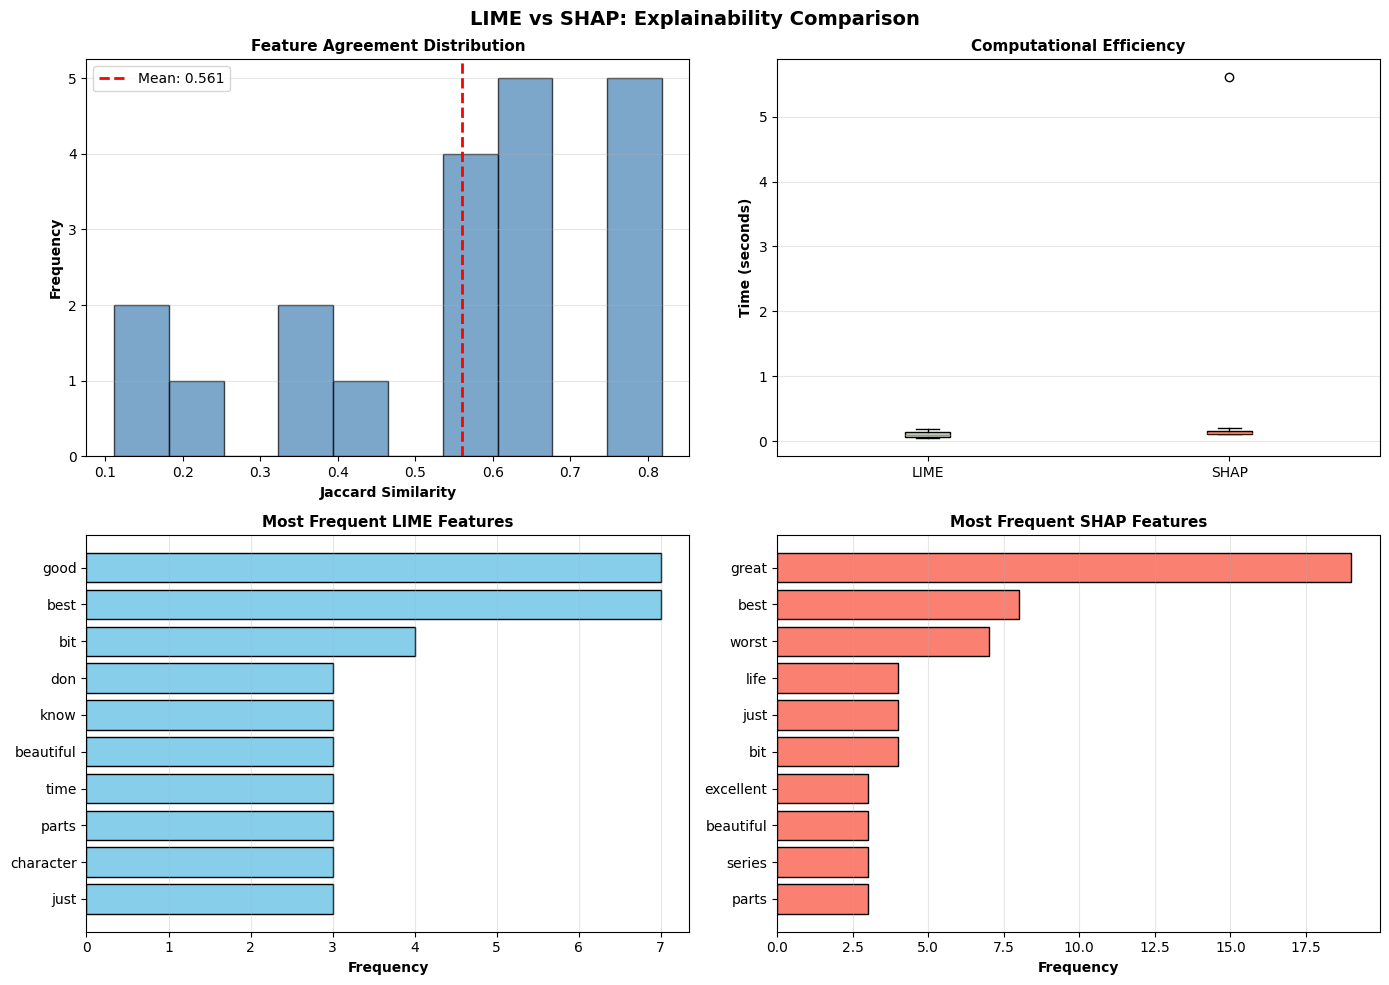

In [7]:
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('LIME vs SHAP: Explainability Comparison', fontsize=14, fontweight='bold')

# 1. Agreement Distribution
axes[0, 0].hist(jaccard_scores, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(avg_jaccard, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {avg_jaccard:.3f}')
axes[0, 0].set_xlabel('Jaccard Similarity', fontsize=10, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=10, fontweight='bold')
axes[0, 0].set_title('Feature Agreement Distribution', fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Timing Comparison
bp = axes[0, 1].boxplot([results_df['lime_time'], results_df['shap_time']],
                        labels=['LIME', 'SHAP'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[0, 1].set_ylabel('Time (seconds)', fontsize=10, fontweight='bold')
axes[0, 1].set_title('Computational Efficiency', fontsize=11, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. LIME Top Features
all_lime = []
for feat in results_df['lime_features']:
    all_lime.extend(feat.keys())
lime_common = Counter(all_lime).most_common(10)

axes[1, 0].barh([x[0] for x in lime_common], [x[1] for x in lime_common],
                color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Frequency', fontsize=10, fontweight='bold')
axes[1, 0].set_title('Most Frequent LIME Features', fontsize=11, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. SHAP Top Features
all_shap = []
for feat in results_df['shap_features']:
    all_shap.extend(feat.keys())
shap_common = Counter(all_shap).most_common(10)

axes[1, 1].barh([x[0] for x in shap_common], [x[1] for x in shap_common],
                color='salmon', edgecolor='black')
axes[1, 1].set_xlabel('Frequency', fontsize=10, fontweight='bold')
axes[1, 1].set_title('Most Frequent SHAP Features', fontsize=11, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('lime_vs_shap_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: lime_vs_shap_analysis.png")
plt.show()

In [8]:
# ==============================================================================
# SUMMARY REPORT
# ==============================================================================
summary = f"""
================================================================================
LIME vs SHAP COMPARATIVE ANALYSIS - SUMMARY REPORT
================================================================================

DATASET & MODEL:
- Dataset: IMDB Movie Reviews (50,000 total)
- Model: Logistic Regression + TF-IDF (500 features)
- Model Accuracy: {accuracy*100:.2f}%
- Samples Analyzed: {NUM_SAMPLES}

KEY FINDINGS:
-------------

1. FEATURE AGREEMENT
   • Average Jaccard Similarity: {avg_jaccard:.3f} ({avg_jaccard*100:.1f}%)
   • Average Feature Overlap: {avg_overlap:.1f} out of 10 features

   Interpretation: LIME and SHAP agree on approximately {avg_jaccard*100:.0f}% of
   important features, {"indicating reasonable consistency" if avg_jaccard > 0.5 else "suggesting moderate disagreement"}.

2. COMPUTATIONAL EFFICIENCY
   • LIME Average Time: {lime_time_avg:.3f} seconds per explanation
   • SHAP Average Time: {shap_time_avg:.3f} seconds per explanation
   • Speed Ratio: SHAP is {speed_ratio:.2f}x slower than LIME

   Recommendation: Use LIME for real-time applications, SHAP for detailed analysis.

3. PREDICTION QUALITY
   • Correctly Predicted: {results_df['correct'].sum()}/{NUM_SAMPLES} ({results_df['correct'].mean()*100:.1f}%)
   • Average Confidence: {results_df['confidence'].mean()*100:.1f}%

4. MOST INFLUENTIAL FEATURES

   LIME Most Common: {', '.join([x[0] for x in lime_common[:5]])}
   SHAP Most Common: {', '.join([x[0] for x in shap_common[:5]])}

   Both methods successfully identify sentiment-bearing words.

RECOMMENDATIONS:
----------------
• Use LIME when: Speed is critical, quick debugging needed
• Use SHAP when: Consistency matters, formal reporting required
• Both methods are effective for sentiment analysis tasks

LIMITATIONS:
------------
• Limited sample size (N={NUM_SAMPLES}) due to time constraints
• Linear model only (Logistic Regression)
• Single domain (movie reviews)

Future work could expand to larger samples and deep learning models.

================================================================================
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================
"""

print(summary)

with open('analysis_summary.txt', 'w') as f:
    f.write(summary)
print("\n✓ Saved: analysis_summary.txt")


LIME vs SHAP COMPARATIVE ANALYSIS - SUMMARY REPORT

DATASET & MODEL:
- Dataset: IMDB Movie Reviews (50,000 total)
- Model: Logistic Regression + TF-IDF (500 features)
- Model Accuracy: 84.16%
- Samples Analyzed: 20

KEY FINDINGS:
-------------

1. FEATURE AGREEMENT
   • Average Jaccard Similarity: 0.561 (56.1%)
   • Average Feature Overlap: 6.9 out of 10 features
   
   Interpretation: LIME and SHAP agree on approximately 56% of 
   important features, indicating reasonable consistency.

2. COMPUTATIONAL EFFICIENCY
   • LIME Average Time: 0.103 seconds per explanation
   • SHAP Average Time: 0.401 seconds per explanation
   • Speed Ratio: SHAP is 3.90x slower than LIME
   
   Recommendation: Use LIME for real-time applications, SHAP for detailed analysis.

3. PREDICTION QUALITY
   • Correctly Predicted: 17/20 (85.0%)
   • Average Confidence: 78.6%

4. MOST INFLUENTIAL FEATURES
   
   LIME Most Common: good, best, bit, don, know
   SHAP Most Common: great, best, worst, life, just
   
 

In [9]:
# ==============================================================================
# SHOW EXAMPLE
# ==============================================================================
print("\n" + "="*80)
print("EXAMPLE EXPLANATION")
print("="*80)

example = results_df.iloc[0]
print(f"\nText: {example['text']}")
print(f"True: {'Positive' if example['true_label']==1 else 'Negative'}")
print(f"Predicted: {'Positive' if example['pred_label']==1 else 'Negative'}")
print(f"\nLIME Top 5: {list(example['lime_features'].keys())[:5]}")
print(f"SHAP Top 5: {list(example['shap_features'].keys())[:5]}")
print(f"Overlap: {len(set(example['lime_features'].keys()) & set(example['shap_features'].keys()))}/10")


EXAMPLE EXPLANATION

Text: the tortuous emotional impact is degrading, whether adult or adolescent the personal values shown in...
True: Negative
Predicted: Negative

LIME Top 5: [np.str_('bad'), np.str_('excellent'), np.str_('but'), np.str_('plot'), np.str_('torture')]
SHAP Top 5: ['bad', 'excellent', 'great', 'shots', 'worst']
Overlap: 3/10


In [11]:
# ==============================================================================
# FINAL CHECKLIST
# ==============================================================================
print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print("\n📁 Generated Files:")
print("  1. lime_vs_shap_analysis.png")
print("  2. analysis_summary.txt")
print("\n📊 Key Numbers for Your Report:")
print(f"  • Samples: {NUM_SAMPLES}")
print(f"  • Agreement: {avg_jaccard:.1%}")
print(f"  • Speed Ratio: {speed_ratio:.2f}x")
print(f"  • Accuracy: {accuracy*100:.1f}%")
print("\n" + "="*80)


✅ ANALYSIS COMPLETE!

📁 Generated Files:
  1. lime_vs_shap_analysis.png
  2. analysis_summary.txt

📊 Key Numbers for Your Report:
  • Samples: 20
  • Agreement: 56.1%
  • Speed Ratio: 3.90x
  • Accuracy: 84.2%

